Load the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                            import pandas as pd

# Load the dataset
data = pd.read_csv('Downloads/crop yrild kn/Crop_Production_Yield_AP_Realistic_2020_2024.csv')

# Display the first few rows
print(data.head())


FileNotFoundError: [Errno 2] No such file or directory: 'Downloads/crop yrild kn/Crop_Production_Yield_AP_Realistic_2020_2024.csv'

Reshape Temporal Features

In [3]:
import numpy as np

# Example: Expand annual rainfall to monthly data (synthetic for demonstration)
temporal_columns = ['Rainfall (mm)', 'Temperature (°C)', 'Humidity (%)']
num_time_steps = 12

temporal_data = []
for _, row in data.iterrows():
    monthly_data = []
    for col in temporal_columns:
        # Split the annual value into monthly approximations
        monthly_values = np.random.normal(loc=row[col] / num_time_steps, scale=5, size=num_time_steps)
        monthly_data.append(monthly_values)
    temporal_data.append(np.array(monthly_data).T)  # Shape (12, len(temporal_columns))

temporal_data = np.array(temporal_data)  # Final shape: (num_samples, 12, len(temporal_columns))


NameError: name 'data' is not defined

Normalize Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Static features
static_columns = ['Land Area (ha)', 'Fertilizer Usage (kg/ha)', 'Irrigation (%)']
static_data = data[static_columns].values
scaler_static = MinMaxScaler()
static_data = scaler_static.fit_transform(static_data)

# Temporal features
temporal_data = temporal_data.reshape(-1, len(temporal_columns))
scaler_temporal = MinMaxScaler()
temporal_data = scaler_temporal.fit_transform(temporal_data).reshape(-1, 12, 1, 1, len(temporal_columns))

# Target variable (Yield)
target_column = 'Yield (t/ha)'
yield_target = data[target_column].values
scaler_target = MinMaxScaler()
yield_target = scaler_target.fit_transform(yield_target.reshape(-1, 1))


Split Data

In [ ]:
from sklearn.model_selection import train_test_split

X_temporal_train, X_temporal_val, X_static_train, X_static_val, y_train, y_val = train_test_split(
    temporal_data, static_data, yield_target, test_size=0.2, random_state=42
)


Verify Dataset Loading

In [ ]:
import pandas as pd

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Crop_Production_Yield_AP_Realistic_2020_2024.csv')

# Print first few rows
print(data.head())

# Check column names
print(data.columns)


        District  Year  Season       Crop  Land Area (ha)  Rainfall (mm)  \
0      Anantapur  2021  Kharif       Rice         3564.27         530.44   
1        Kurnool  2024  Kharif      Maize         3159.45         818.03   
2        Krishna  2024  Kharif     Cotton         1441.89         972.97   
3  Visakhapatnam  2021    Rabi  Sugarcane         9651.67         926.87   
4  East Godavari  2024    Rabi     Pulses         8517.90        1391.84   

   Temperature (°C)  Humidity (%)  Irrigation (%)  Fertilizer Usage (kg/ha)  \
0             37.21         76.43           63.57                    183.77   
1             28.40         76.30           74.99                    152.69   
2             30.59         65.69           49.73                     81.86   
3             27.58         85.02           57.36                    155.83   
4             32.42         72.64           90.60                    170.55   

   Yield (t/ha)  
0          0.66  
1          1.06  
2          2.5

Verify Temporal Data Preprocessing

In [ ]:
print(f"Temporal data shape: {temporal_data.shape}")  # Expected: (num_samples, 12, 1, 1, 3)


Temporal data shape: (20000, 12, 1, 1, 3)


Verify Static Features

In [ ]:
print(f"Static features shape: {static_data.shape}")  # Expected: (num_samples, 3)
print(f"Static features (first row): {static_data[0]}")


Static features shape: (20000, 3)
Static features (first row): [0.32251173 0.86476572 0.47957143]


Verify Train-Test Splits

In [ ]:
print(f"X_temporal_train shape: {X_temporal_train.shape}")
print(f"X_static_train shape: {X_static_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_temporal_train shape: (16000, 12, 1, 1, 3)
X_static_train shape: (16000, 3)
y_train shape: (16000, 1)


Hybrid Model Code: 3D-CNN + RNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the hybrid model
def create_hybrid_model(input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers
    x = layers.Conv3D(32, kernel_size=(3, 1, 1), activation='relu')(temporal_input)
    # Removed MaxPooling3D as pooling reduces spatial dimensions to 0
    x = layers.Conv3D(64, kernel_size=(3, 1, 1), activation='relu')(x)
    # Removed another MaxPooling3D layer
    x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu')(x)
    # Flatten the 3D features
    x = layers.Flatten()(x)

    # Use a Dense layer to adjust the dimensionality
    x = layers.Dense(128, activation='relu')(x)  # Dense layer to adjust the shape

    # LSTM part
    # We don’t reshape to (12, 128), just pass it through a dense layer to adjust input for LSTM
    x = layers.Reshape((1, 128))(x)  # Reshape output to 1 time step with 128 features

    x = layers.LSTM(128, return_sequences=False)(x)  # LSTM layer

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Merging both temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Define input shapes
# temporal data shape: (num_samples, 12, 1, 1, 3), static data shape: (num_samples, 3)
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Create the model
model = create_hybrid_model(input_shape_temporal, input_shape_static)

# Print model summary to ensure it is properly defined
model.summary()

# Example: Assuming X_temporal_train, X_static_train, y_train are already prepared
# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=50,
    batch_size=32
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 12, 1, 1, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 10, 1, 1, 32)   │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 8, 1, 1, 64)    │          6,208 │ conv3d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_6 (Conv3D)         │ (None, 6, 1, 1, 128)   │         24,704 │ conv3d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 768)            │              0 │ conv3d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │         98,432 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 128)         │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │        131,584 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 131)            │              0 │ lstm[0][0],            │
│ (Concatenate)             │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 128)            │         16,896 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │          8,256 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │             65 │ dense_9[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 286,465 (1.09 MB)

 Trainable params: 286,465 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0145 - val_loss: 0.0111
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0100 - val_loss: 0.0107
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0099 - val_loss: 0.0107
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 12/50
500/500 ━━━━━━━━━━━━━━

In [ ]:
# Ensure temporal data has the expected shape (num_samples, 12, 1, 1, 3)
X_temporal_train = X_temporal_train.reshape((-1, 12, 1, 1, 3))
X_temporal_val = X_temporal_val.reshape((-1, 12, 1, 1, 3))

print("X_temporal_train shape:", X_temporal_train.shape)
print("X_temporal_val shape:", X_temporal_val.shape)


X_temporal_train shape: (16000, 12, 1, 1, 3)
X_temporal_val shape: (4000, 12, 1, 1, 3)


In [ ]:
# Example: Ensure temporal and static data have the same number of samples
X_temporal_train, X_temporal_val, X_static_train, X_static_val, y_train, y_val = train_test_split(
    temporal_data, static_data, yield_target, test_size=0.2, random_state=42
)

# Check the shapes to ensure they match
print(f"X_temporal_train shape: {X_temporal_train.shape}")
print(f"X_static_train shape: {X_static_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_temporal_train shape: (16000, 12, 1, 1, 3)
X_static_train shape: (16000, 3)
y_train shape: (16000, 1)


In [ ]:
X_temporal_train = X_temporal_train.reshape(-1, 12, 1, 1, 3)
X_temporal_val = X_temporal_val.reshape(-1, 12, 1, 1, 3)


In [ ]:
model.fit([X_temporal_train, X_static_train], y_train, epochs=50, batch_size=32, validation_data=([X_temporal_val, X_static_val], y_val))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0127 - mae: 0.0806 - val_loss: 0.0116 - val_mae: 0.0760
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0128 - mae: 0.0806 - val_loss: 0.0128 - val_mae: 0.0823
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0130 - mae: 0.0820 - val_loss: 0.0114 - val_mae: 0.0760
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0126 - mae: 0.0802 - val_loss: 0.0120 - val_mae: 0.0774
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0132 - mae: 0.0824 - val_loss: 0.0113 - val_mae: 0.0757
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0127 - mae: 0.0809 - val_loss: 0.0118 - val_mae: 0.0775
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0127 - mae: 0.0808 - val_loss: 0.0117 - val_mae: 0.0766
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0122 - mae: 0.0788 - val_loss: 0.0117 - val_mae: 0.0766
Epoch 9/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - los

In [ ]:
print(f"X_temporal_train shape: {X_temporal_train.shape}")
print(f"X_static_train shape: {X_static_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_temporal_train shape: (16000, 12, 1, 1, 3)
X_static_train shape: (16000, 3)
y_train shape: (16000, 1)


In [ ]:
X_temporal_train = X_temporal_train[:16000]
print(f"X_temporal_train shape: {X_temporal_train.shape}")


X_temporal_train shape: (16000, 12, 1, 1, 3)


In [ ]:
X_temporal_train, X_temporal_val, X_static_train, X_static_val, y_train, y_val = train_test_split(
    X_temporal_train, X_static_train, y_train, test_size=0.2, random_state=42
)


In [ ]:
print(f"X_temporal_train shape: {X_temporal_train.shape}")
print(f"X_static_train shape: {X_static_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_temporal_train shape: (12800, 12, 1, 1, 3)
X_static_train shape: (12800, 3)
y_train shape: (12800, 1)


Ensure temporal and static data have the same number of samples

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)
X_temporal_train, X_temporal_val, X_static_train, X_static_val, y_train, y_val = train_test_split(
    X_temporal_train, X_static_train, y_train, test_size=0.2, random_state=42
)

# Verify the shapes after the split
print(f"X_temporal_train shape: {X_temporal_train.shape}")
print(f"X_temporal_val shape: {X_temporal_val.shape}")
print(f"X_static_train shape: {X_static_train.shape}")
print(f"X_static_val shape: {X_static_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_temporal_train shape: (12800, 12, 1, 1, 3)
X_temporal_val shape: (3200, 12, 1, 1, 3)
X_static_train shape: (12800, 3)
X_static_val shape: (3200, 3)
y_train shape: (12800, 1)
y_val shape: (3200, 1)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Ensure data types are correct
X_temporal_train = X_temporal_train.astype('float32')
X_static_train = X_static_train.astype('float32')
y_train = y_train.astype('float32')

X_temporal_val = X_temporal_val.astype('float32')
X_static_val = X_static_val.astype('float32')
y_val = y_val.astype('float32')

# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=50,
    batch_size=32
)


Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0248 - mae: 0.1219 - val_loss: 0.0206 - val_mae: 0.1116
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0202 - mae: 0.1125 - val_loss: 0.0202 - val_mae: 0.1114
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0198 - mae: 0.1110 - val_loss: 0.0200 - val_mae: 0.1120
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0199 - mae: 0.1112 - val_loss: 0.0205 - val_mae: 0.1114
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0195 - mae: 0.1101 - val_loss: 0.0201 - val_mae: 0.1122
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0201 - mae: 0.1118 - val_loss: 0.0202 - val_mae: 0.1114
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0197 - mae: 0.1106 - val_loss: 0.0209 - val_mae: 0.1152
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0190 - mae: 0.1095 - val_loss: 0.0204 - val_mae: 0.1123
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms

Evaluate the Model

In [ ]:
# Evaluate the model on validation data
val_loss, val_mae = model.evaluate([X_temporal_val, X_static_val], y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation MAE: {val_mae}")



80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - mae: 0.1258
Validation Loss: 0.026588687673211098
Validation MAE: 0.12613466382026672


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


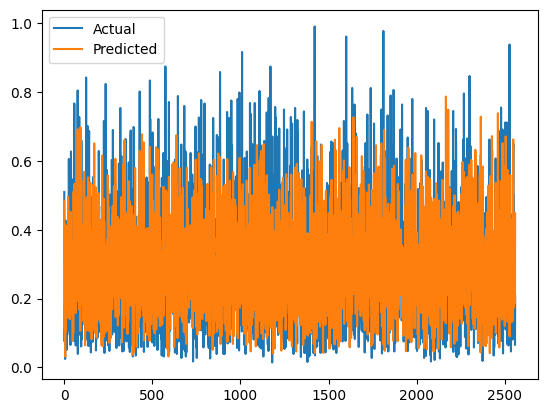

In [ ]:
# Make predictions on new data (e.g., test set)
y_pred = model.predict([X_temporal_val, X_static_val])

# Optionally, you can plot or evaluate the predictions
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.plot(y_val, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Absolute Error (MAE): 0.13014015555381775
Mean Squared Error (MSE): 0.028326252475380898
R-Squared (R²): 0.05961078405380249


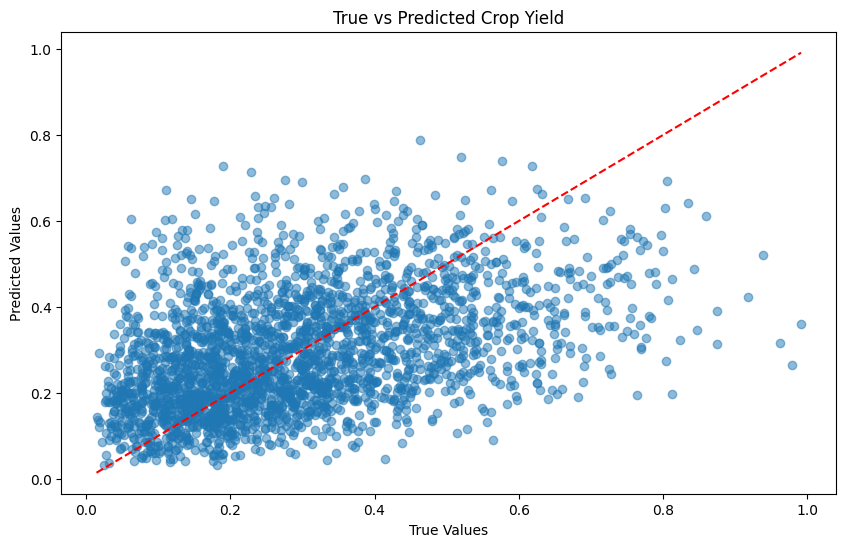

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming your model is already trained and you have X_temporal_val, X_static_val, and y_val

# Get predictions from the model
y_pred = model.predict([X_temporal_val, X_static_val])

# Calculate MAE, MSE, and R²
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")

# Plot True vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # ideal line (y = x)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Crop Yield')
plt.show()


In [ ]:
import numpy as np

# Define an acceptable margin (e.g., within 5% of the true value)
threshold = 0.05  # 5%

# Calculate the absolute percentage error
percentage_error = np.abs((y_val - y_pred) / y_val)

# Define the accuracy as the percentage of predictions within the threshold
accuracy = np.mean(percentage_error < threshold)

print(f"Regression-like Accuracy (within {threshold*100}%): {accuracy * 100}%")


Regression-like Accuracy (within 5.0%): 6.992187499999999%


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.3396e-04 - val_loss: 0.0280
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 7.8355e-04 - val_loss: 0.0275
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 7.8546e-04 - val_loss: 0.0277
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.9953e-04 - val_loss: 0.0275
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7.4190e-04 - val_loss: 0.0287
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 7.7842e-04 - val_loss: 0.0280
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.3177e-04 - val_loss: 0.0271
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 6.2590e-04 - val_loss: 0.0271
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.1310e-04 - val_loss: 0.0281
Epoch 10/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 5.8800e-04 - val_loss: 0.0273
Epoch 11/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 6.1723e-04 - val_loss: 0.02

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Absolute Error (MAE): 0.12691915035247803
Mean Squared Error (MSE): 0.02688666619360447
R-Squared (R²): 0.10740292072296143


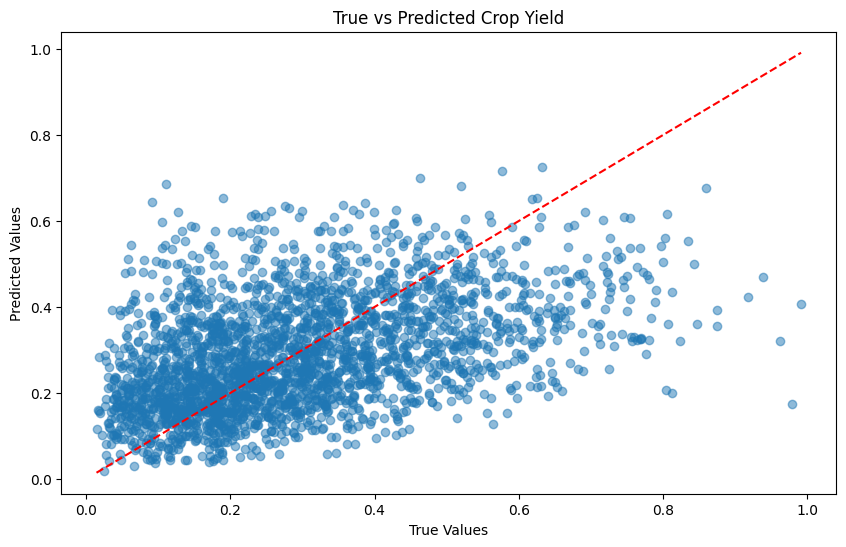

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming your model is already trained and you have X_temporal_val, X_static_val, and y_val

# Get predictions from the model
y_pred = model.predict([X_temporal_val, X_static_val])

# Calculate MAE, MSE, and R²
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-Squared (R²): {r2}")

# Plot True vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # ideal line (y = x)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Crop Yield')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Define the hybrid model
def create_hybrid_model(input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers
    x = layers.Conv3D(32, kernel_size=(3, 1, 1), activation='relu')(temporal_input)
    x = layers.Conv3D(64, kernel_size=(3, 1, 1), activation='relu')(x)
    x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu')(x)

    # Flatten the 3D features
    x = layers.Flatten()(x)

    # Dense layer to adjust dimensionality
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # L2 Regularization

    # Reshape output to 1 time step with 128 features for LSTM
    x = layers.Reshape((1, 128))(x)

    # Add a Bidirectional LSTM layer for better temporal learning
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Merging both temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # Dropout for regularization
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Define input shapes
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Example: Assuming X_temporal_train, X_static_train, y_train are already prepared

# Scale the data
scaler_temporal = StandardScaler()
X_temporal_train = scaler_temporal.fit_transform(X_temporal_train.reshape(-1, X_temporal_train.shape[-1])).reshape(X_temporal_train.shape)
X_temporal_val = scaler_temporal.transform(X_temporal_val.reshape(-1, X_temporal_val.shape[-1])).reshape(X_temporal_val.shape)

scaler_static = StandardScaler()
X_static_train = scaler_static.fit_transform(X_static_train)
X_static_val = scaler_static.transform(X_static_val)

# Create the model
model = create_hybrid_model(input_shape_temporal, input_shape_static)

# Print model summary to ensure it is properly defined
model.summary()

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1  # Reduce learning rate after 10 epochs
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# ModelCheckpoint to save the best model
# ModelCheckpoint to save the best model
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True)


# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler_callback, checkpoint_callback]
)

# Evaluate the model on validation data
y_pred = model.predict([X_temporal_val, X_static_val])

# Calculate R² and MAE
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-Squared (R²): {r2}')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 12, 1, 1, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_18 (Conv3D)        │ (None, 10, 1, 1, 32)   │            320 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 8, 1, 1, 64)    │          6,208 │ conv3d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 6, 1, 1, 128)   │         24,704 │ conv3d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 768)            │              0 │ conv3d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         98,432 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 128)         │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 256)            │        263,168 │ reshape_5[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 259)            │              0 │ bidirectional_2[0][0], │
│ (Concatenate)             │                        │                │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │         33,280 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          8,256 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 434,433 (1.66 MB)

 Trainable params: 434,433 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.5511 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0212 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0211 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0202 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0202 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0199 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0202 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0197 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0192 - val_loss: 0.0201 - learning_rate: 0.0010

1D-CNN + Transformer + Dense Network

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 12, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 10, 32)         │            320 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 8, 64)          │          6,208 │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 4, 64)          │              0 │ conv1d_10[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 2, 128)         │         24,704 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 1, 128)         │              0 │ conv1d_11[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 128)            │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 1, 128)         │              0 │ flatten_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 1, 128)         │        263,808 │ reshape_14[0][0],      │
│ (MultiHeadAttention)      │                        │                │ reshape_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 1, 128)         │              0 │ reshape_14[0][0],      │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 1, 128)         │            256 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_49 (Dense)          │ (None, 1, 128)         │         16,512 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 1, 128)         │         16,512 │ dense_49[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 1, 128)         │              0 │ layer_normalization_8… │
│                           │                        │                │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 1, 128)         │            256 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_15 (Reshape) 

 Total params: 353,793 (1.35 MB)

 Trainable params: 353,793 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.0953 - val_loss: 0.0205
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0210 - val_loss: 0.0199
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0203 - val_loss: 0.0201
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0206 - val_loss: 0.0209
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0202 - val_loss: 0.0205
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0206 - val_loss: 0.0208
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0198 - val_loss: 0.0209
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0200 - val_loss: 0.0210
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0196 - val_loss: 0.0203
Epoch 10/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0194 - val_loss: 0.0208
Epoch 11/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0194 - val_loss: 0.0214
Epoch 12/50
320/320 ━━━━━━━━━━━━━━━━━━

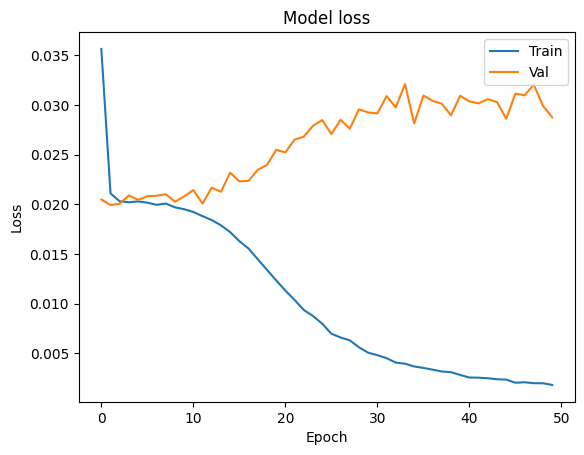

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the Transformer block
def transformer_block(inputs, num_heads, ff_dim):
    # Multi-Head Attention layer
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    # Add & Normalize
    x = layers.Add()([inputs, attention])
    x = layers.LayerNormalization()(x)

    # Feed Forward layer
    ff = layers.Dense(ff_dim, activation='relu')(x)
    ff = layers.Dense(inputs.shape[-1])(ff)  # Same output dimension as input
    x = layers.Add()([x, ff])  # Skip connection
    x = layers.LayerNormalization()(x)

    return x

# Define the hybrid model: 1D-CNN + Transformer + Dense
def create_hybrid_model(input_shape_temporal, input_shape_static, num_heads=4, ff_dim=128):
    # Temporal Input (1D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 1D CNN layers for temporal features
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(temporal_input)  # 1D convolution for temporal sequence
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)  # Another 1D convolution
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu')(x)  # 1D convolution
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Flatten the output of CNN
    x = layers.Flatten()(x)

    # LSTM part (for temporal sequence learning)
    x = layers.Reshape((1, x.shape[-1]))(x)  # Reshape for Transformer input
    x = transformer_block(x, num_heads=num_heads, ff_dim=ff_dim)

    # Reshape transformer output to (batch_size, 128)
    x = layers.Reshape((x.shape[1]*x.shape[2],))(x)  # Flatten the transformer output

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Merging both temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Define input shapes
input_shape_temporal = (12, 3)  # Temporal input shape (12 time steps, 3 features at each time step)
input_shape_static = (3,)  # Static features (e.g., land area, fertilizer usage)

# Reshape your data if necessary to match the expected input shape
X_temporal_train = X_temporal_train.reshape(-1, 12, 3)  # Reshape to (num_samples, 12, 3)
X_temporal_val = X_temporal_val.reshape(-1, 12, 3)

# Create the model
model = create_hybrid_model(input_shape_temporal, input_shape_static)

# Print model summary to ensure it is properly defined
model.summary()

# ModelCheckpoint to save the best model during training
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=50,  # Train for 100 epochs
    batch_size=32,
    callbacks=[checkpoint_callback]  # Save the best model during training
)

# After training, you can evaluate the model and check R² and other metrics
y_pred = model.predict([X_temporal_val, X_static_val])

# Evaluate the model performance
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

r_squared = r2_score(y_val, y_pred)
print(f"R-Squared (R²): {r_squared}")

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the optimized hybrid model with regularization, dropout, and bidirectional LSTM
def create_optimized_model(input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers with L2 regularization
    x = layers.Conv3D(64, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
    x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Flatten()(x)

    # Dense layer with Dropout and L2 Regularization
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)  # Dropout to prevent overfitting

    # Reshape to make it compatible with LSTM
    x = layers.Reshape((1, 128))(x)

    # Bidirectional LSTM layer
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Combine temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

    return model

# Example input shapes
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Create the optimized model
model = create_optimized_model(input_shape_temporal, input_shape_static)

# Print model summary to verify the structure
model.summary()

# Prepare the callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

# Model evaluation after training
loss = model.evaluate([X_temporal_val, X_static_val], y_val)
print(f"Validation Loss: {loss}")

# Predicting using the trained model
y_pred = model.predict([X_temporal_val, X_static_val])

# Performance metrics
from sklearn.metrics import mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-Squared (R²)
r2 = r2_score(y_val, y_pred)
print(f"R-Squared (R²): {r2}")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 12, 1, 1, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 10, 1, 1, 64)   │            640 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 8, 1, 1, 128)   │         24,704 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 1024)           │              0 │ conv3d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │        131,200 │ flatten_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 1, 128)         │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 256)            │        263,168 │ reshape_7[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 259)            │              0 │ bidirectional_4[0][0], │
│ (Concatenate)             │                        │                │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │         33,280 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 64)             │          8,256 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1)              │             65 │ dense_23[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 461,313 (1.76 MB)

 Trainable params: 461,313 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.7874 - val_loss: 0.0215
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0210 - val_loss: 0.0204
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0199 - val_loss: 0.0204
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0201 - val_loss: 0.0203
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0199 - val_loss: 0.0203
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0201 - val_loss: 0.0204
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0194 - val_loss: 0.0202
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0199 - val_loss: 0.0199
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0196 - val_loss: 0.0201
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0198 - val_loss: 0.0201
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0200 - val_loss: 0.0203
Epoch 12/100
320/320 ━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score
import keras_tuner as kt

# Define the optimized hybrid model with regularization, dropout, and bidirectional LSTM
def create_optimized_model_with_hp(hp, input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers with L2 regularization
    x = layers.Conv3D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
    x = layers.Conv3D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64), kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Flatten()(x)

    # Dense layer with Dropout and L2 Regularization
    x = layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)  # Dropout to prevent overfitting

    # Reshape the output of the dense layer to (batch_size, timesteps, features) for the LSTM
    x = layers.Reshape((1, -1))(x)  # Reshaping into (batch_size, 1, features)

    # Bidirectional LSTM layer
    x = layers.Bidirectional(layers.LSTM(hp.Int('lstm_units', min_value=64, max_value=256, step=64), return_sequences=False))(x)

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Combine temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

    return model

# Example input shapes
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Load your data
# Assuming X_temporal_train, X_static_train, y_train, X_temporal_val, X_static_val, y_val are already defined

# Define the tuner (Hyperband)
tuner = kt.Hyperband(
    lambda hp: create_optimized_model_with_hp(hp, input_shape_temporal, input_shape_static),  # Pass the input shapes through a lambda function
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='tune_hybrid_model',
    overwrite=True
)

# Start the hyperparameter search
tuner.search([X_temporal_train, X_static_train], y_train, epochs=10, batch_size=32, validation_data=([X_temporal_val, X_static_val], y_val))

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters: ", best_hps)

# Get the best model with the selected hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True)

history = best_model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

# Model evaluation after training
loss = best_model.evaluate([X_temporal_val, X_static_val], y_val)
print(f"Validation Loss: {loss}")

# Predicting using the trained model
y_pred = best_model.predict([X_temporal_val, X_static_val])

# Performance metrics
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_val, y_pred)
print(f"R-Squared (R²): {r2}")


Trial 30 Complete [00h 01m 06s]
val_loss: 0.020038563758134842

Best val_loss So Far: 0.019889643415808678
Total elapsed time: 00h 21m 56s
Best Hyperparameters:  <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e31bea912a0>
Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 1.0107 - val_loss: 0.0207
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0198 - val_loss: 0.0206
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0197 - val_loss: 0.0203
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.0198 - val_loss: 0.0206
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 0.0195 - val_loss: 0.0203
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0196 - val_loss: 0.0202
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0195 - val_loss: 0.0202
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 9/100
320/320 ━━━━━━━━━

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00


Hybrid 3D CNN + GRU Model Code


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score
import keras_tuner as kt

# Define the optimized hybrid model with regularization, dropout, and GRU
def create_3dcnn_gru_model_with_hp(hp, input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers with L2 regularization
    x = layers.Conv3D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32), kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
    x = layers.Conv3D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64), kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Flatten()(x)

    # Dense layer with Dropout and L2 Regularization
    x = layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)  # Dropout to prevent overfitting

    # Reshape the output of the dense layer to (batch_size, timesteps, features) for the GRU
    x = layers.Reshape((1, -1))(x)  # Reshaping into (batch_size, 1, features)

    # GRU layer
    x = layers.GRU(hp.Int('gru_units', min_value=64, max_value=256, step=64), return_sequences=False)(x)

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Combine temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

    return model

# Example input shapes
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Load your data
# Assuming X_temporal_train, X_static_train, y_train, X_temporal_val, X_static_val, y_val are already defined

# Define the tuner (Hyperband)
tuner = kt.Hyperband(
    lambda hp: create_3dcnn_gru_model_with_hp(hp, input_shape_temporal, input_shape_static),  # Pass the input shapes through a lambda function
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_dir_gru',
    project_name='tune_hybrid_model_gru',
    overwrite=True
)

# Start the hyperparameter search
tuner.search([X_temporal_train, X_static_train], y_train, epochs=10, batch_size=32, validation_data=([X_temporal_val, X_static_val], y_val))

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters: ", best_hps)

# Get the best model with the selected hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('best_model_gru.keras', save_best_only=True)

history = best_model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

# Model evaluation after training
loss = best_model.evaluate([X_temporal_val, X_static_val], y_val)
print(f"Validation Loss: {loss}")

# Predicting using the trained model
y_pred = best_model.predict([X_temporal_val, X_static_val])

# Performance metrics
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_val, y_pred)
print(f"R-Squared (R²): {r2}")


Trial 30 Complete [00h 01m 29s]
val_loss: 0.012052626349031925

Best val_loss So Far: 0.011882387101650238
Total elapsed time: 00h 17m 24s
Best Hyperparameters:  <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e74da4c6950>
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7543 - val_loss: 0.0134
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0137 - val_loss: 0.0140
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0131 - val_loss: 0.0142
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0128 - val_loss: 0.0132
Epoch 9/100
500/500 ━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, r2_score
import keras_tuner as kt

# Define the optimized hybrid model with regularization, dropout, and GRU
def create_3dcnn_gru_model_with_hp(hp, input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers with L2 regularization
    x = layers.Conv3D(hp.Int('conv1_filters', min_value=64, max_value=128, step=32), kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
    x = layers.Conv3D(hp.Int('conv2_filters', min_value=128, max_value=256, step=64), kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling3D(pool_size=(2, 1, 1))(x)

    # Flatten and pass through Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # Increased Dropout to 50%

    # Reshape the output of the dense layer to (batch_size, timesteps, features) for the GRU
    x = layers.Reshape((1, -1))(x)  # Reshaping into (batch_size, 1, features)

    # GRU layer with more units
    x = layers.GRU(hp.Int('gru_units', min_value=128, max_value=512, step=64), return_sequences=False)(x)

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Combine temporal and static inputs
    combined = layers.concatenate([x, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(256, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)  # Increased Dropout
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

    return model

# Example input shapes
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Load your data
# Assuming X_temporal_train, X_static_train, y_train, X_temporal_val, X_static_val, y_val are already defined

# Define the tuner (Hyperband)
tuner = kt.Hyperband(
    lambda hp: create_3dcnn_gru_model_with_hp(hp, input_shape_temporal, input_shape_static),  # Pass the input shapes through a lambda function
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_dir_gru',
    project_name='tune_hybrid_model_gru',
    overwrite=True
)

# Start the hyperparameter search
tuner.search([X_temporal_train, X_static_train], y_train, epochs=10, batch_size=32, validation_data=([X_temporal_val, X_static_val], y_val))

# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials()[0].hyperparameters
print("Best Hyperparameters: ", best_hps)

# Get the best model with the selected hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('best_model_gru.keras', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = best_model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_callback, checkpoint_callback, lr_scheduler]
)

# Model evaluation after training
loss = best_model.evaluate([X_temporal_val, X_static_val], y_val)
print(f"Validation Loss: {loss}")

# Predicting using the trained model
y_pred = best_model.predict([X_temporal_val, X_static_val])

# Performance metrics
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_val, y_pred)
print(f"R-Squared (R²): {r2}")


Trial 30 Complete [00h 01m 54s]
val_loss: 0.011954820714890957

Best val_loss So Far: 0.011954820714890957
Total elapsed time: 00h 37m 02s
Best Hyperparameters:  <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7e74c361f160>
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 3.3298 - val_loss: 0.7803 - learning_rate: 1.0000e-04
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.5141 - val_loss: 0.0960 - learning_rate: 1.0000e-04
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0640 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0183 - val_loss: 0.0143 - learning_rate: 1.0000e-04
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0145 - val_loss: 0.0132 - learning_rate: 1.0000e-04
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0138 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print(type(X_temporal_train), X_temporal_train.shape)
print(type(X_static_train), X_static_train.shape)
print(type(y_train), y_train.shape)


<class 'numpy.ndarray'> (16000, 12, 1, 1, 3)
<class 'numpy.ndarray'> (16000, 3)
<class 'numpy.ndarray'> (16000, 1)


 Hybrid CNN 3D + GRU with Attention

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Attention
from sklearn.metrics import mean_absolute_error, r2_score

# Define the optimized hybrid model with CNN 3D, GRU, and Attention
def create_hybrid_model(input_shape_temporal, input_shape_static):
    # Temporal Input (3D-CNN part)
    temporal_input = layers.Input(shape=input_shape_temporal)

    # 3D CNN layers
    x = layers.Conv3D(64, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
    x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.MaxPooling3D(pool_size=(2, 1, 1))(x)  # Add max-pooling layer

    # Flatten after CNN layers
    x = layers.Flatten()(x)

    # Dense layer with Dropout and L2 Regularization
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)  # Dropout to prevent overfitting

    # Reshape to make it compatible with GRU
    x = layers.Reshape((1, 128))(x)

    # GRU layer
    x = layers.GRU(128, return_sequences=True)(x)

    # Attention layer
    attention = Attention()([x, x])  # Apply attention to the GRU outputs
    attention_output = layers.GlobalAveragePooling1D()(attention)  # Global pooling to reduce dimensions

    # Static Input (for other features like Land Area, Fertilizer Usage, etc.)
    static_input = layers.Input(shape=input_shape_static)

    # Combine temporal and static inputs
    combined = layers.concatenate([attention_output, static_input])

    # Fully connected layers for prediction
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='linear')(x)  # Linear activation for regression

    # Define the model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

    return model

# Example input shapes (Update according to your dataset)
input_shape_temporal = (12, 1, 1, 3)  # 12 months, 1x1 spatial grid, 3 features (rainfall, temperature, humidity)
input_shape_static = (3,)  # Land Area, Fertilizer Usage, Irrigation

# Create the hybrid model
model = create_hybrid_model(input_shape_temporal, input_shape_static)

# Print model summary to verify the structure
model.summary()

# Prepare the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_gru_attention_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

# Model evaluation after training
loss = model.evaluate([X_temporal_val, X_static_val], y_val)
print(f"Validation Loss: {loss}")

# Predicting using the trained model
y_pred = model.predict([X_temporal_val, X_static_val])

# Performance metrics
mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

r2 = r2_score(y_val, y_pred)
print(f"R-Squared (R²): {r2}")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 12, 1, 1, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_9 (Conv3D)         │ (None, 10, 1, 1, 64)   │            640 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_10 (Conv3D)        │ (None, 8, 1, 1, 128)   │         24,704 │ conv3d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_3           │ (None, 4, 1, 1, 128)   │              0 │ conv3d_10[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 512)            │              0 │ max_pooling3d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │         65,664 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 128)            │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 128)         │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_3 (GRU)               │ (None, 1, 128)         │         99,072 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1, 128)         │              0 │ gru_3[0][0],           │
│                           │                        │                │ gru_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ attention_1[0][0]      │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 131)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 128)            │         16,896 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 64)             │          8,256 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │             65 │ dense_16[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 215,297 (841.00 KB)

 Trainable params: 215,297 (841.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.7271 - val_loss: 0.0132
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0141 - val_loss: 0.0122
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0135 - val_loss: 0.0121
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0132 - val_loss: 0.0122
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0138 - val_loss: 0.0117
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0127 - val_loss: 0.0116
Epoch 9/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0129 - val_loss: 0.0116
Epoch 10/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 11/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0137 - val_loss: 0.0147
Epoch 12/100
400/400 ━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, r2_score

# Define model input shapes
input_shape_temporal = (12, 1, 1, 3)  # (time_steps, height, width, channels)
input_shape_static = (3,)  # Static features

# Temporal Input (3D-CNN part)
temporal_input = layers.Input(shape=input_shape_temporal)

# Add more 3D CNN layers
x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
x = layers.Conv3D(256, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling3D(pool_size=(2, 1, 1))(x)

# Reshape output to be 3D for GRU (batch_size, time_steps, features)
x = layers.Reshape((-1, 256))(x)

# Add GRU layer
x = layers.GRU(256, return_sequences=True)(x)

# Use a Multi-Head Attention layer
attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)

# Flatten and concatenate with static input
attention_output = layers.GlobalAveragePooling1D()(attention)

# Static Input
static_input = layers.Input(shape=input_shape_static)

# Concatenate attention output with static features
combined = layers.concatenate([attention_output, static_input])

# Fully connected layers with dropout for regularization
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.5)(x)  # Increase dropout rate
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Increase dropout rate

# Output layer (regression)
output = layers.Dense(1, activation='linear')(x)

# Define model
model = models.Model(inputs=[temporal_input, static_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_gru_attention_model.keras', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Evaluate the model on the validation data
val_loss = model.evaluate([X_temporal_val, X_static_val], y_val)
print(f'Validation Loss: {val_loss}')

# Make predictions on the validation set
y_pred = model.predict([X_temporal_val, X_static_val])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-Squared (R²) score
r2 = r2_score(y_val, y_pred)
print(f'R-Squared (R²): {r2}')

# If you want to save the model:
model.save('final_cnn_gru_attention_model.keras')


Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - loss: 0.3583 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 0.0160 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - loss: 0.0147 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - loss: 0.0141 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - loss: 0.0135 - val_loss: 0.0157 - learning_rate: 0.0010
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.0139 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.0130 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.0133 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 9/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - loss: 0.0135 - val_loss: 0.0114 - learn

In [ ]:
import numpy as np
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report

# Define model input shapes
input_shape_temporal = (12, 1, 1, 3)  # (time_steps, height, width, channels)
input_shape_static = (3,)  # Static features

# Temporal Input (3D-CNN part)
temporal_input = layers.Input(shape=input_shape_temporal)

# Add more 3D CNN layers
x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
x = layers.Conv3D(256, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling3D(pool_size=(2, 1, 1))(x)

# Reshape output to be 3D for GRU (batch_size, time_steps, features)
x = layers.Reshape((-1, 256))(x)

# Add GRU layer
x = layers.GRU(256, return_sequences=True)(x)

# Use a Multi-Head Attention layer
attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)

# Flatten and concatenate with static input
attention_output = layers.GlobalAveragePooling1D()(attention)

# Static Input
static_input = layers.Input(shape=input_shape_static)

# Concatenate attention output with static features
combined = layers.concatenate([attention_output, static_input])

# Fully connected layers with dropout for regularization
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer (binary classification)
output = layers.Dense(1, activation='sigmoid')(x)

# Define model
model = models.Model(inputs=[temporal_input, static_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_gru_attention_model_binary_classification.keras', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Assuming X_temporal_train, X_static_train, y_train, X_temporal_val, X_static_val, y_val are defined
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate([X_temporal_val, X_static_val], y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Make predictions on the validation set
y_pred_prob = model.predict([X_temporal_val, X_static_val])

# Ensure y_val is binary and integer type
y_val_binary = np.round(y_val).astype(int)  # Rounds any continuous values to 0 or 1 and converts to int

# Convert probabilities to binary class labels using a threshold (e.g., 0.5)
y_pred_labels = (y_pred_prob > 0.5).astype(int).flatten()  # Flatten to ensure shape consistency

# Generate the classification report
report = classification_report(y_val_binary, y_pred_labels)
print(report)

# Save the final model
model.save('final_cnn_gru_attention_model_binary_classification.keras')


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 3.1701e-05 - loss: 0.8877 - val_accuracy: 2.5000e-04 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 68ms/step - accuracy: 2.3442e-05 - loss: 0.5691 - val_accuracy: 2.5000e-04 - val_loss: 0.5582 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 1.3125e-04 - loss: 0.5679 - val_accuracy: 2.5000e-04 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 1.5373e-04 - loss: 0.5673 - val_accuracy: 2.5000e-04 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 8.7797e-05 - loss: 0.5657 - val_accuracy: 2.5000e-04 - val_loss: 0.5578 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 1.0306e-04 - loss: 0.5665 - val_accuracy: 2.5000e-04 - val_loss: 0.5591 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━

**Final reports of 3dcnn+gru+attention mechanism**

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 5.9050e-05 - loss: 0.8837 - val_accuracy: 2.5000e-04 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 1.0778e-04 - loss: 0.5711 - val_accuracy: 2.5000e-04 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.1051e-04 - loss: 0.5670 - val_accuracy: 2.5000e-04 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 8.4699e-05 - loss: 0.5665 - val_accuracy: 2.5000e-04 - val_loss: 0.5594 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 3.5424e-05 - loss: 0.5644 - val_accuracy: 2.5000e-04 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.8335e-04 - loss: 0.5635 - val_accuracy: 2.5000e-04 - val_loss: 0.5617 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━

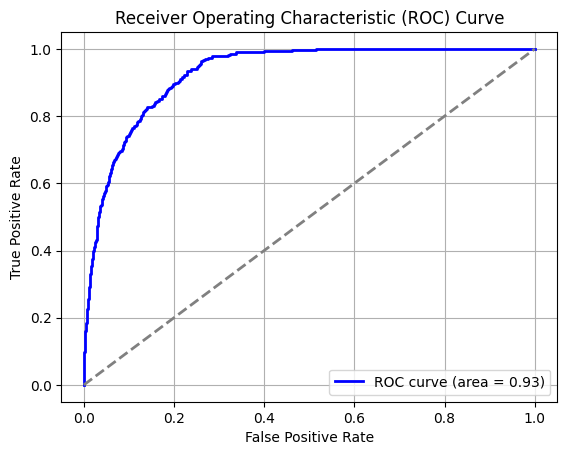

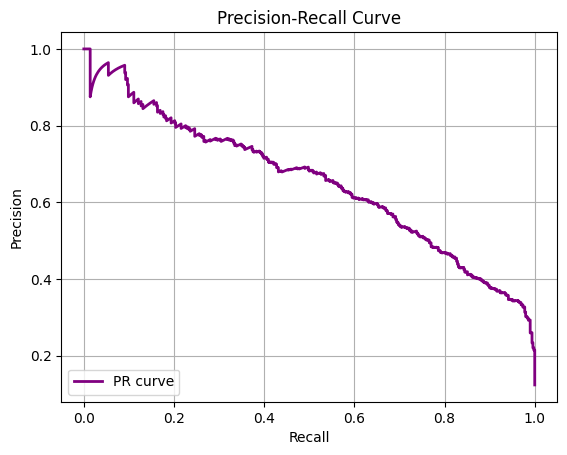

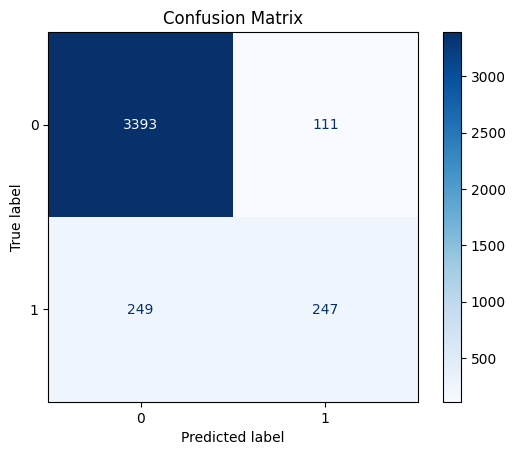

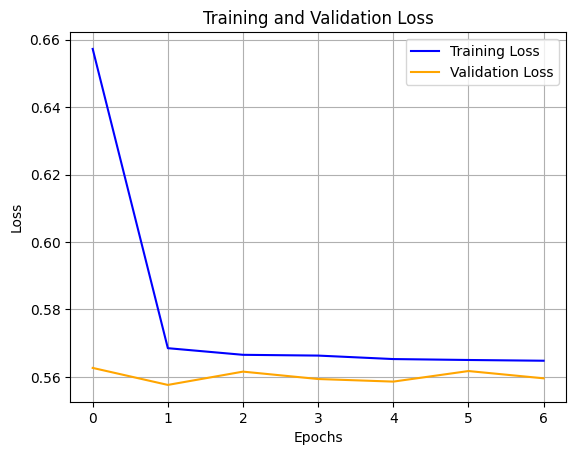

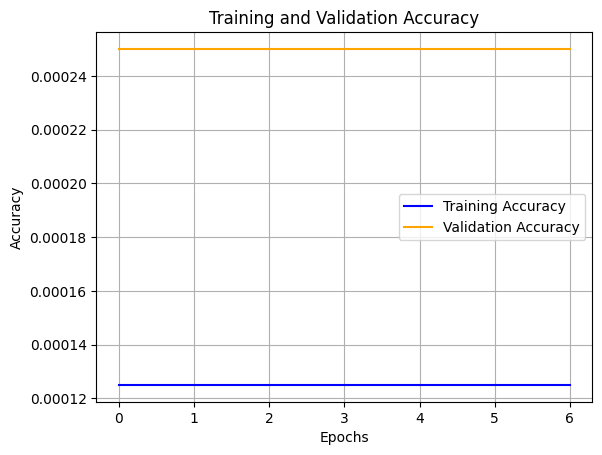

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Define model input shapes
input_shape_temporal = (12, 1, 1, 3)  # (time_steps, height, width, channels)
input_shape_static = (3,)  # Static features

# Temporal Input (3D-CNN part)
temporal_input = layers.Input(shape=input_shape_temporal)

# Add more 3D CNN layers
x = layers.Conv3D(128, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(temporal_input)
x = layers.Conv3D(256, kernel_size=(3, 1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling3D(pool_size=(2, 1, 1))(x)

# Reshape output to be 3D for GRU (batch_size, time_steps, features)
x = layers.Reshape((-1, 256))(x)

# Add GRU layer
x = layers.GRU(256, return_sequences=True)(x)

# Use a Multi-Head Attention layer
attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)

# Flatten and concatenate with static input
attention_output = layers.GlobalAveragePooling1D()(attention)

# Static Input
static_input = layers.Input(shape=input_shape_static)

# Concatenate attention output with static features
combined = layers.concatenate([attention_output, static_input])

# Fully connected layers with dropout for regularization
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Output layer (binary classification)
output = layers.Dense(1, activation='sigmoid')(x)

# Define model
model = models.Model(inputs=[temporal_input, static_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_gru_attention_model_binary_classification.keras', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Assuming X_temporal_train, X_static_train, y_train, X_temporal_val, X_static_val, y_val are defined
history = model.fit(
    [X_temporal_train, X_static_train], y_train,
    validation_data=([X_temporal_val, X_static_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate([X_temporal_val, X_static_val], y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Make predictions on the validation set
y_pred_prob = model.predict([X_temporal_val, X_static_val])

# Ensure y_val is binary and integer type
y_val_binary = np.round(y_val).astype(int)  # Rounds any continuous values to 0 or 1 and converts to int

# Convert probabilities to binary class labels using a threshold (e.g., 0.5)
y_pred_labels = (y_pred_prob > 0.5).astype(int).flatten()  # Flatten to ensure shape consistency

# Generate the classification report
report = classification_report(y_val_binary, y_pred_labels)
print(report)

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_val_binary, y_pred_prob)
roc_auc = roc_auc_score(y_val_binary, y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_binary, y_pred_prob)

plt.figure()
plt.plot(recall, precision, color='purple', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val_binary, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Learning Curves (Loss and Accuracy)
# Plot training and validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Save the final model
model.save('final_cnn_gru_attention_model_binary_classification.keras')


In [ ]:
pip install shap

In [ ]:
data.columns

Index(['District', 'Year', 'Season', 'Crop', 'Land Area (ha)', 'Rainfall (mm)',
       'Temperature (°C)', 'Humidity (%)', 'Irrigation (%)',
       'Fertilizer Usage (kg/ha)', 'Yield (t/ha)'],
      dtype='object')

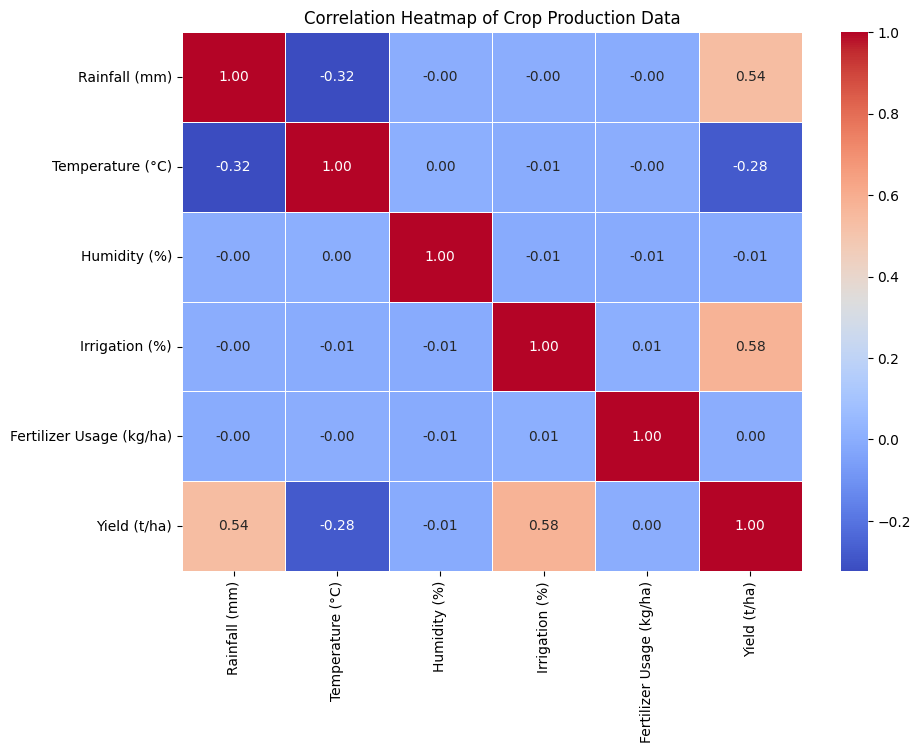

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('Crop_Production_Yield_AP_Realistic_2020_2024.csv')

# Select numeric columns for correlation
numeric_data = data[['Rainfall (mm)', 'Temperature (°C)', 'Humidity (%)', 'Irrigation (%)', 'Fertilizer Usage (kg/ha)', 'Yield (t/ha)']]

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Crop Production Data')
plt.show()


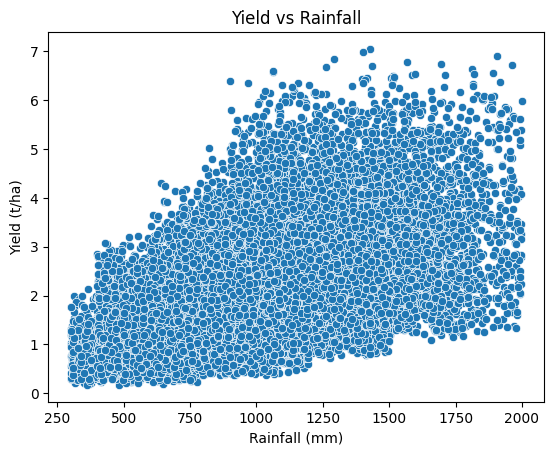

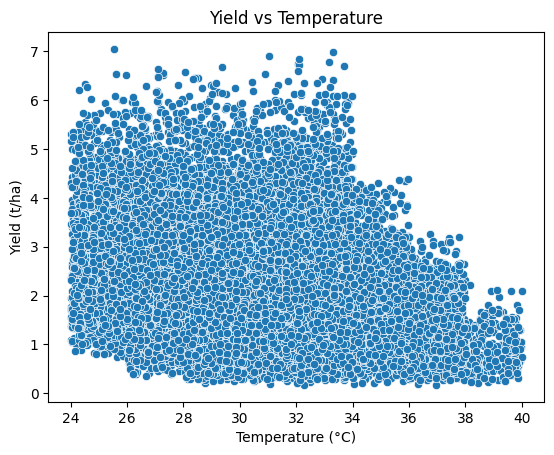

In [ ]:
# Scatter plot between Yield and Rainfall
sns.scatterplot(x='Rainfall (mm)', y='Yield (t/ha)', data=data)
plt.title('Yield vs Rainfall')
plt.show()

# Scatter plot between Yield and Temperature
sns.scatterplot(x='Temperature (°C)', y='Yield (t/ha)', data=data)
plt.title('Yield vs Temperature')
plt.show()


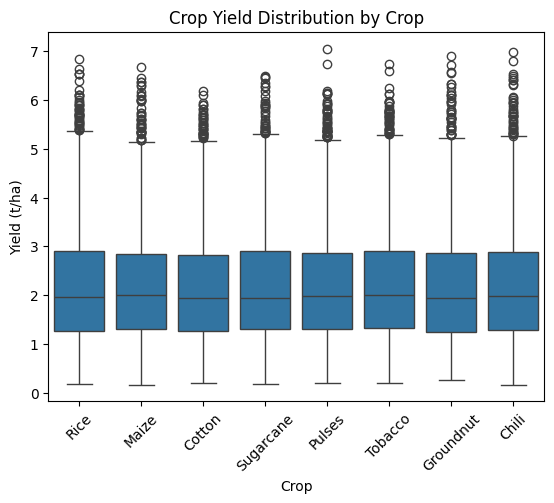

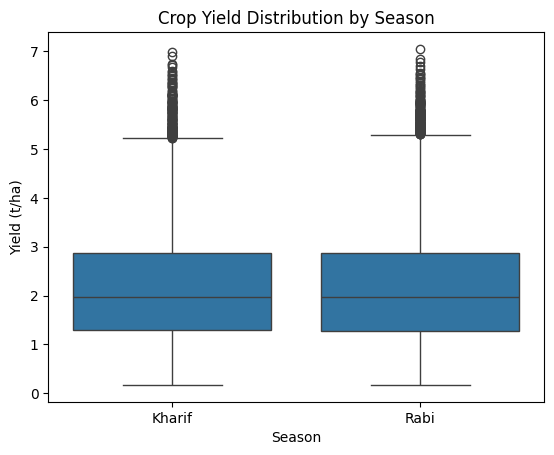

In [ ]:
# Boxplot for Yield by Crop type
sns.boxplot(x='Crop', y='Yield (t/ha)', data=data)
plt.title('Crop Yield Distribution by Crop')
plt.xticks(rotation=45)
plt.show()

# Boxplot for Yield by Season
sns.boxplot(x='Season', y='Yield (t/ha)', data=data)
plt.title('Crop Yield Distribution by Season')
plt.show()


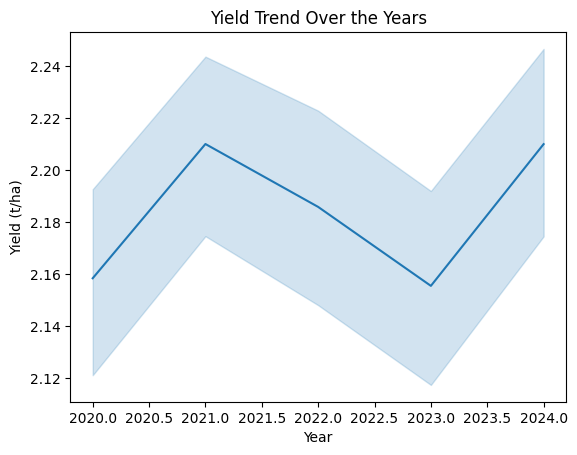

In [ ]:
# Line plot showing trends in Yield over the years
sns.lineplot(x='Year', y='Yield (t/ha)', data=data)
plt.title('Yield Trend Over the Years')
plt.show()


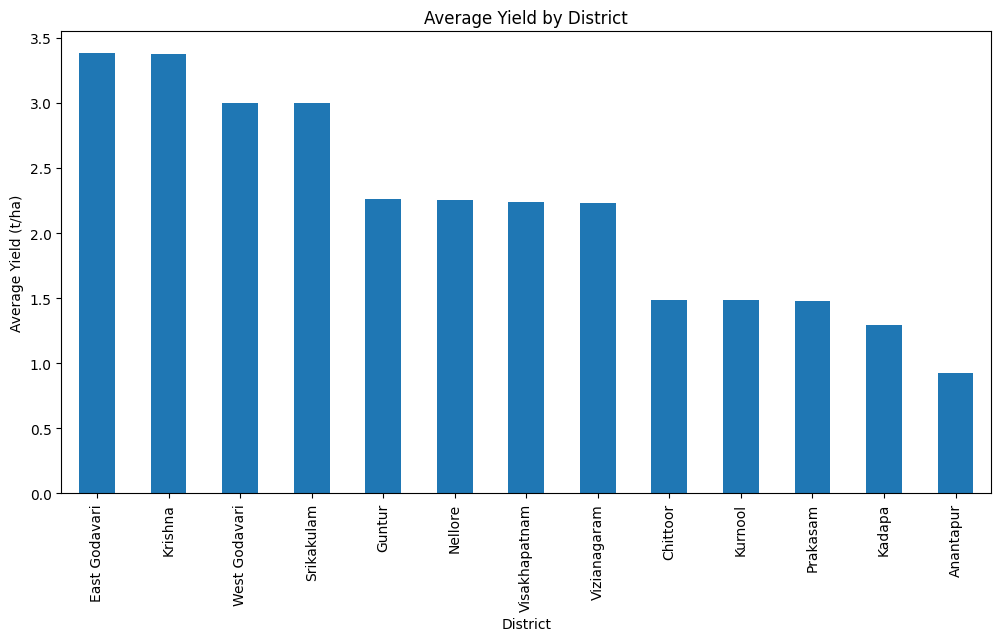

In [ ]:
# Bar plot for average yield by District
avg_yield_by_district = data.groupby('District')['Yield (t/ha)'].mean().sort_values(ascending=False)
avg_yield_by_district.plot(kind='bar', figsize=(12, 6))
plt.title('Average Yield by District')
plt.ylabel('Average Yield (t/ha)')
plt.show()


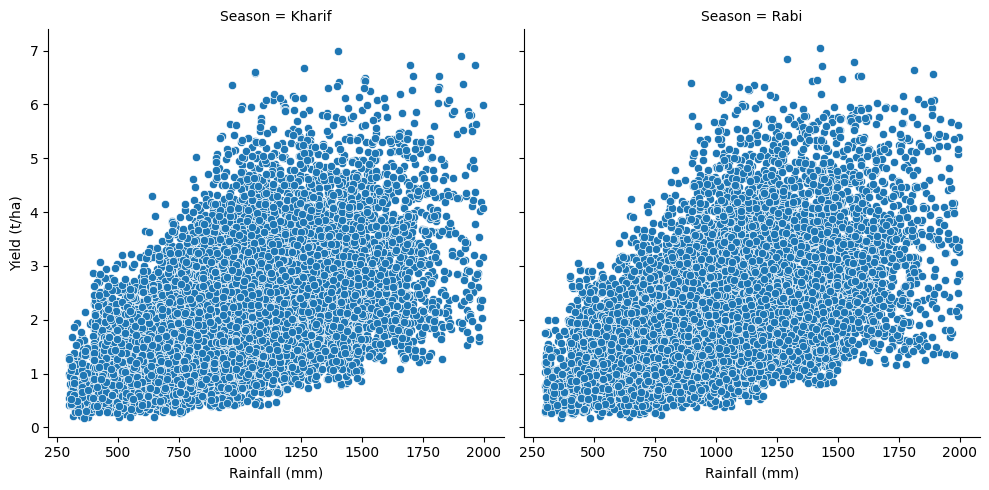

In [ ]:
g = sns.FacetGrid(data, col="Season", height=5)
g.map(sns.scatterplot, "Rainfall (mm)", "Yield (t/ha)")
plt.show()


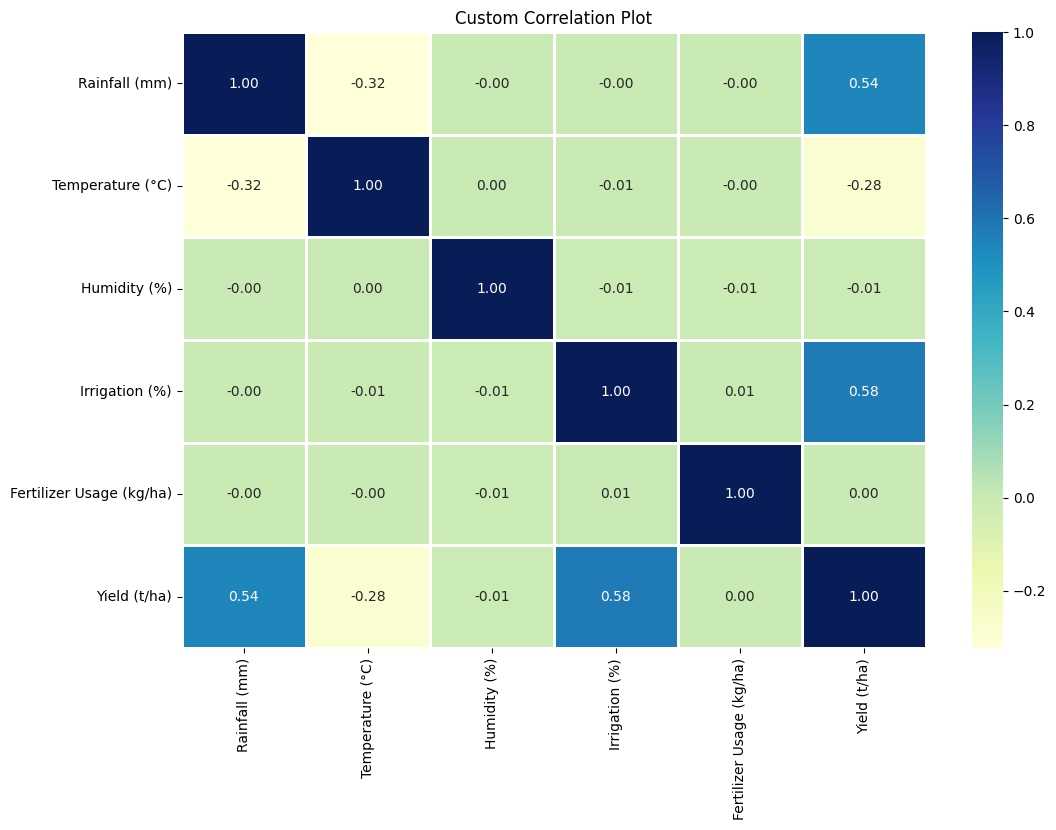

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a custom correlation plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=1)
plt.title('Custom Correlation Plot')
plt.show()


Pairplot

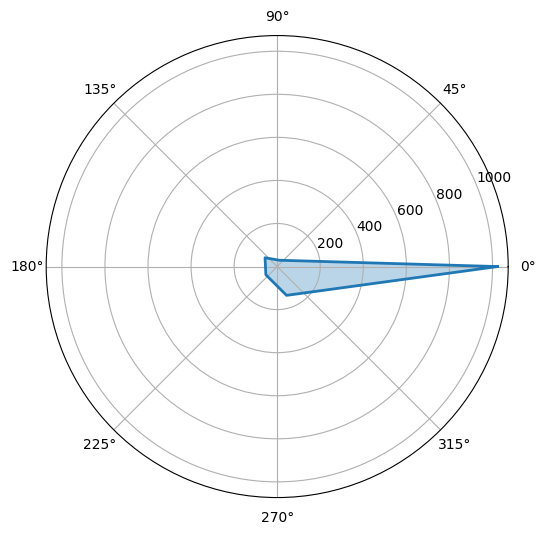

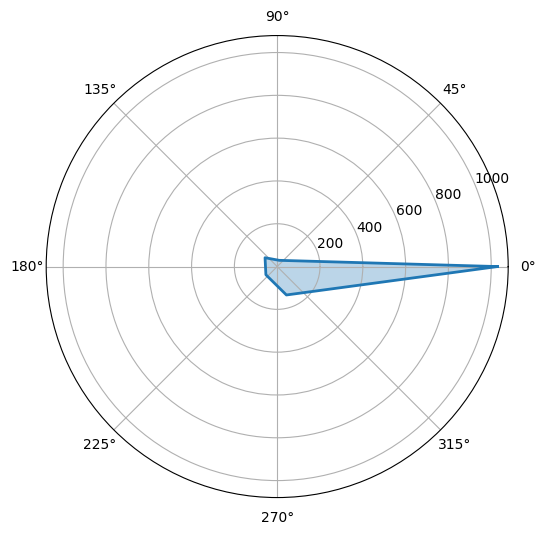

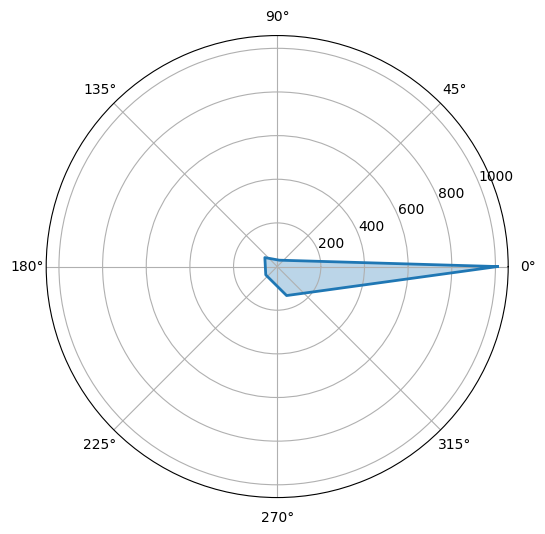

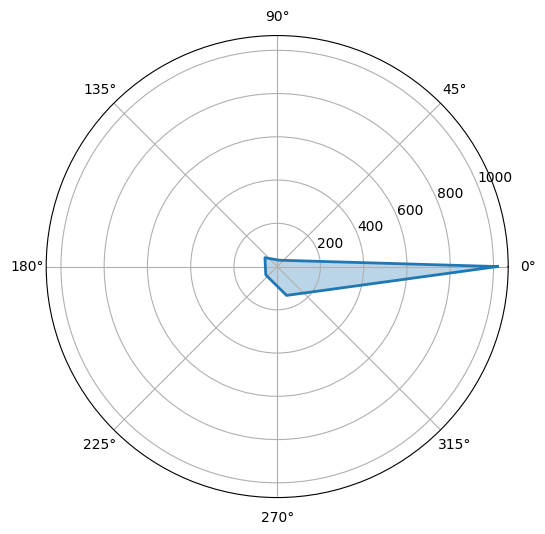

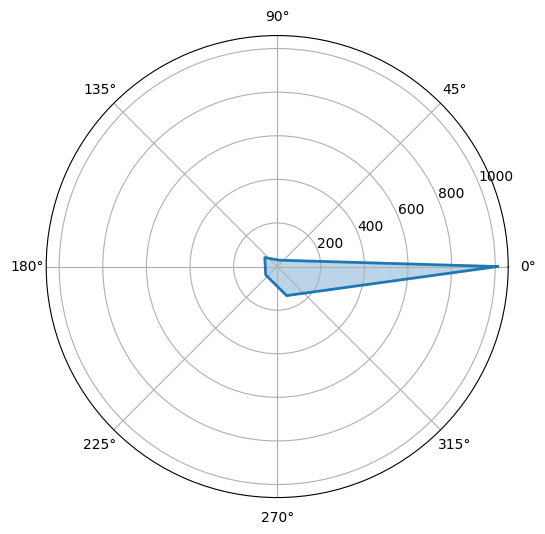

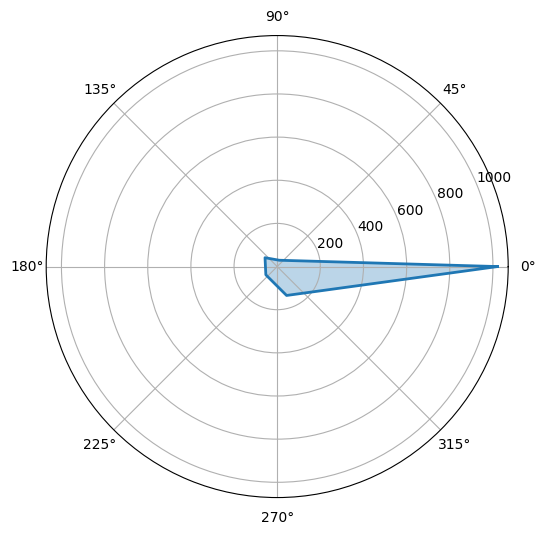

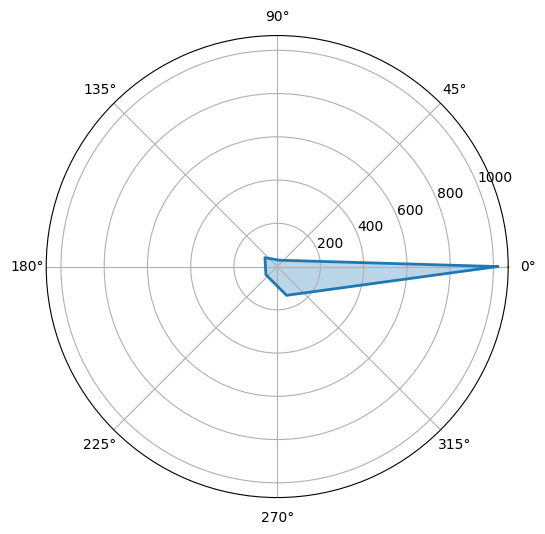

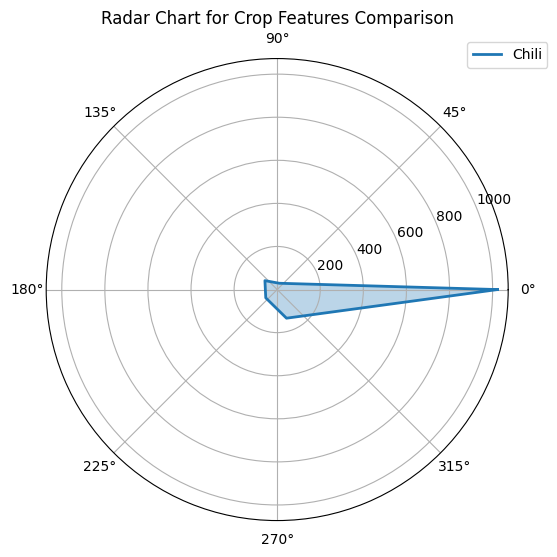

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data for radar chart
crops = data['Crop'].unique()
features = ['Rainfall (mm)', 'Temperature (°C)', 'Humidity (%)', 'Irrigation (%)', 'Fertilizer Usage (kg/ha)']

for crop in crops:
    crop_data = data[data['Crop'] == crop][features].mean()
    values = crop_data.values.tolist()
    values += values[:1]  # Close the loop
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]

    # Create radar chart
    plt.figure(figsize=(6, 6))
    plt.subplot(111, polar=True)
    plt.plot(angles, values, linewidth=2, linestyle='solid', label=crop)
    plt.fill(angles, values, alpha=0.3)

plt.title('Radar Chart for Crop Features Comparison')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.show()


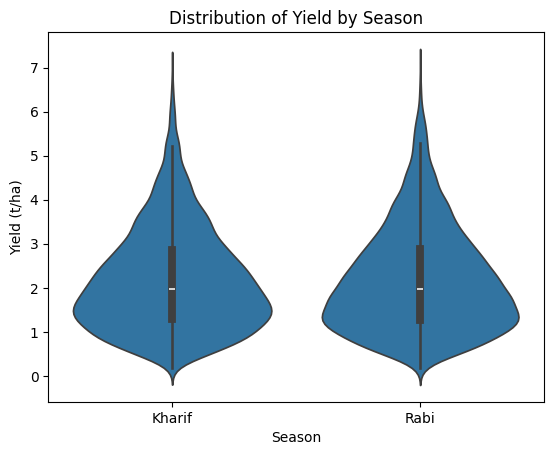

In [ ]:
sns.violinplot(x='Season', y='Yield (t/ha)', data=data)
plt.title('Distribution of Yield by Season')
plt.show()


In [ ]:
sns.scatterplot(x='Temperature (掳C)', y='Irrigation (%)', data=data)
plt.title('Scatter Plot between Feature1 and Feature2')
plt.show()


ValueError: Could not interpret value `Temperature (掳C)` for `x`. An entry with this name does not appear in `data`.

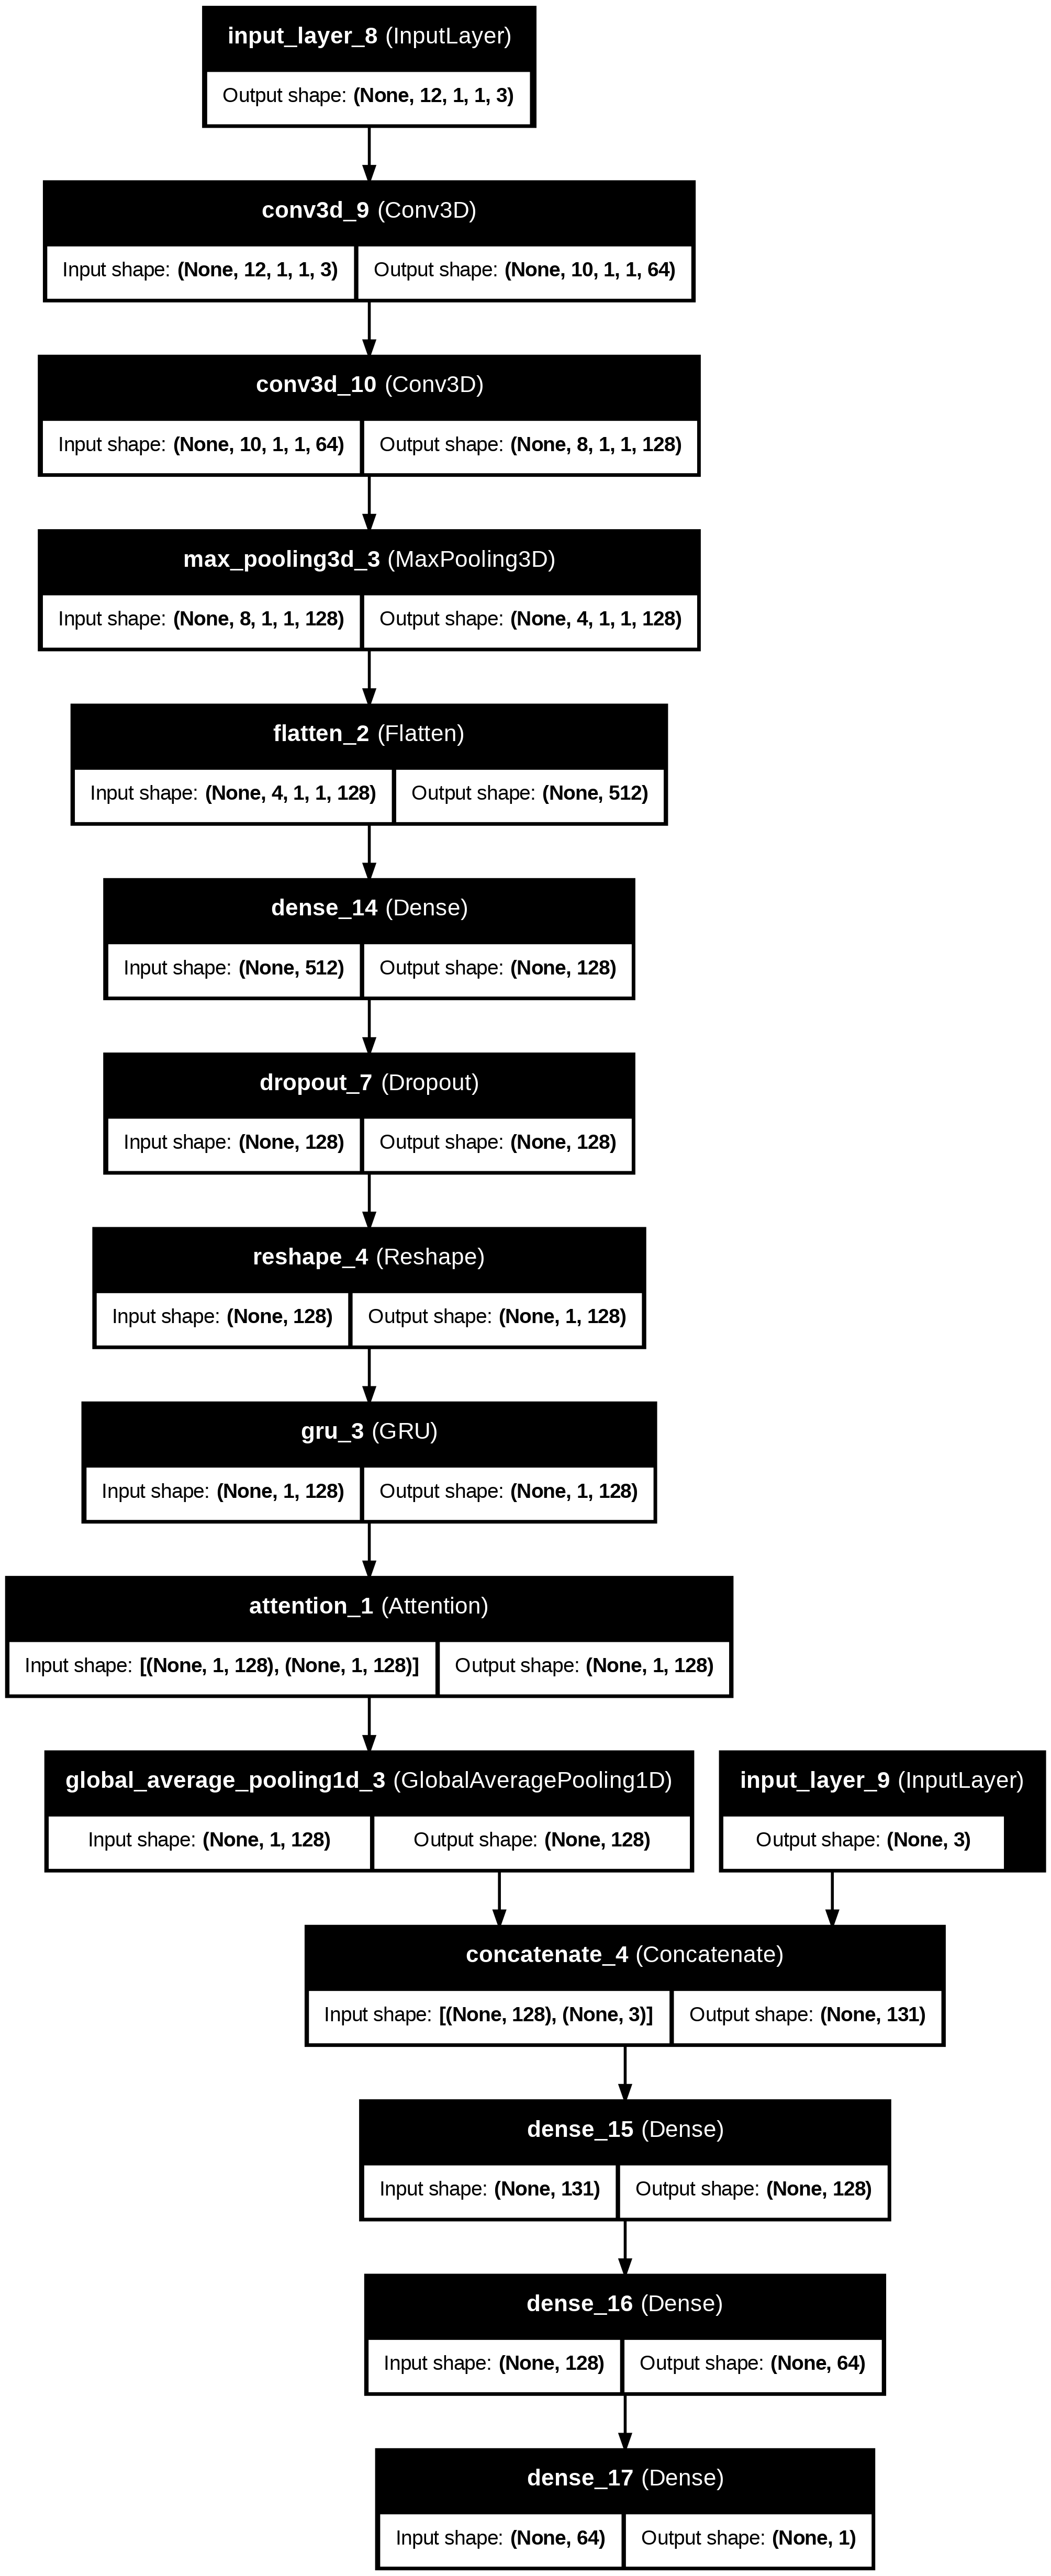

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
def model_predict(inputs):
    return model.predict([inputs[0], inputs[1]])


In [ ]:
print(type(background_temporal))  # Should be <class 'numpy.ndarray'>
print(type(background_static))    # Should be <class 'numpy.ndarray'>


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
pip install shap


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the trained model (if saved)
model = load_model('/content/final_cnn_gru_attention_model_binary_classification.keras')  # Update filename if needed

# Load dataset (Ensure categorical encoding is done for District, Season, and Crop)
df = pd.read_csv('/content/drive/MyDrive/Crop_Production_Yield_AP_Realistic_2020_2024.csv')  # Replace with actual file

# Define feature columns (Ensure proper preprocessing has been applied)
feature_cols = [
    "District", "Year", "Season", "Crop", "Land Area (ha)", "Rainfall (mm)",
    "Temperature (°C)", "Humidity (%)", "Irrigation (%)", "Fertilizer Usage (kg/ha)"
]
X = df[feature_cols]
y = df["Yield (t/ha)"]

# Convert categorical features into numerical (if not already encoded)
X = pd.get_dummies(X, columns=["District", "Season", "Crop"], drop_first=True)

# Define time steps and features for temporal data
num_time_steps = 12  # Define based on dataset (adjust accordingly)
num_features = 3  # Number of features in temporal data

# Adjust the number of samples to be a multiple of num_time_steps
num_samples = X.shape[0] // num_time_steps
adjusted_size = num_samples * num_time_steps
X = X.iloc[:adjusted_size]  # Truncate extra rows

X_temporal = X[['Rainfall (mm)', 'Temperature (°C)', 'Humidity (%)']].values.reshape(num_samples, num_time_steps * num_features)
X_static = X[['Land Area (ha)', 'Irrigation (%)', "Fertilizer Usage (kg/ha)"]].values[:num_samples]

# Combine temporal and static features
X_combined = np.concatenate([X_temporal, X_static], axis=1)

# Define function for model predictions
def model_predict(inputs):
    temporal_input = inputs[:, :num_time_steps * num_features].reshape(-1, num_time_steps, 1, 1, num_features)
    static_input = inputs[:, num_time_steps * num_features:]
    return model.predict([temporal_input, static_input])

# Create SHAP KernelExplainer with a small sample reference set
background_samples = 100  # Use a subset for KernelExplainer to reduce computation
explainer = shap.KernelExplainer(model_predict, X_combined[:background_samples])

# Compute SHAP values
shap_values = explainer.shap_values(X_combined, nsamples=100)

# Combine feature names
feature_names_temporal = [f"{feat}_t{t}" for t in range(num_time_steps) for feat in ["Rainfall (mm)", "Temperature (°C)", "Humidity (%)"]]
feature_names_static = ["Land Area (ha)", "Irrigation (%)", "Fertilizer Usage (kg/ha)"]
feature_names_combined = feature_names_temporal + feature_names_static

# Feature Importance Plot
shap.summary_plot(shap_values, features=X_combined, feature_names=feature_names_combined)

# SHAP Dependence Plot for a specific feature
shap.dependence_plot("Fertilizer Usage (kg/ha)", shap_values, X_combined)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


  0%|          | 0/1666 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
 92/313 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step

KeyboardInterrupt: 